<a href="https://colab.research.google.com/github/jadhav-rakesh/Time_Series_Forecasting/blob/main/time_series_forecasting_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

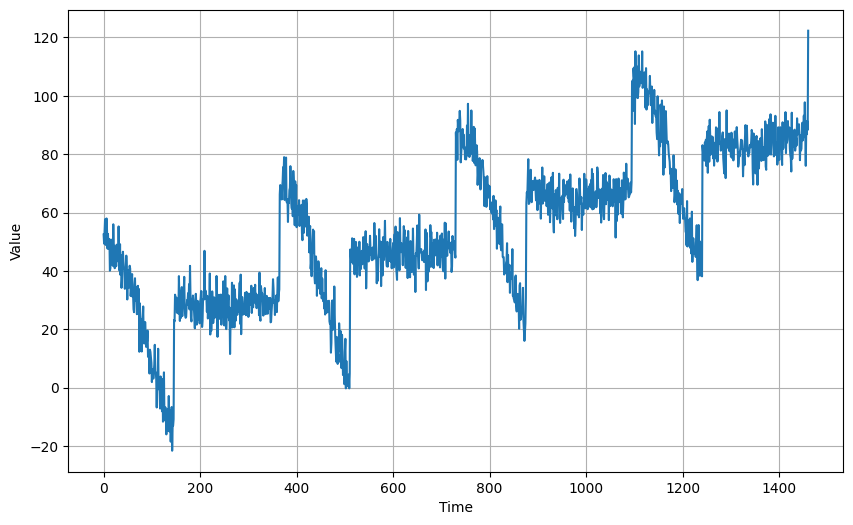

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [16]:
def sequential_window_dataset(series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [7]:
class ResetStateCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        for layer in self.model.layers:
            if isinstance(layer, keras.layers.RNN) and layer.stateful:
                layer.reset_states()

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
batch_size = 32
train_set = sequential_window_dataset(x_train, window_size, batch_size)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(window_size, 1), batch_size=batch_size),
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch:10e-8 * 10**(epoch / 30)
)

reset_states = ResetStateCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 71.8355 - mae: 62.9845 - learning_rate: 1.0000e-07
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 68.8892 - mae: 59.6377 - learning_rate: 1.0798e-07
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 62.5112 - mae: 53.1000 - learning_rate: 1.1659e-07
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 53.7022 - mae: 54.2008

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 53.3980 - mae: 43.9965 - learning_rate: 1.2589e-07
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 42.7068 - mae: 33.2807 - learning_rate: 1.3594e-07
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 33.1621 - mae: 23.3997 - learning_rate: 1.4678e-07
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 31.9697 - mae: 23.5273 - learning_rate: 1.5849e-07
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 38.5154 - mae: 29.6117 - learning_rate: 1.7113e-07
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 40.8416 - mae: 30.9358 - learning_rate: 1.8478e-07
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 37.2825 - mae: 26.7817 - learning_rate: 1.9953e-07
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 31.4201 - mae: 21.9207 - learning_rate: 2.1544e-07
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 30.8590 - mae: 23.0910 - learning_rate: 2.3263e-07
Epoch 13/100
2/2 ━━━━━━━━━━━

(1e-08, 0.0001, 0.0, 30.0)

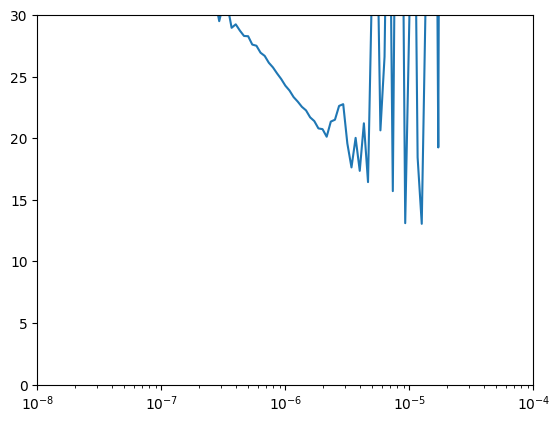

In [9]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
batch_size = 32

train_set = sequential_window_dataset(x_train, window_size, batch_size)
valid_set = sequential_window_dataset(x_valid, window_size, batch_size)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(window_size, 1), batch_size=batch_size),
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x * 200.0)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=50)

reset_states = ResetStateCallback()

history = model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, reset_states])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


      1/Unknown 2s 2s/step - loss: 156.8176 - mae: 157.3176

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 156.8176 - mae: 117.9882
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 155.6453 - mae: 117.1090
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 153.4162 - mae: 115.4371
Epoch 4/500


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 150.2326 - mae: 113.0494
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 146.1886 - mae: 110.0165
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 141.3683 - mae: 106.4012
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 135.8446 - mae: 102.2585
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 129.6847 - mae: 97.6385 
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 122.9473 - mae: 92.5854 
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 115.6877 - mae: 87.1405
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 107.9570 - mae: 81.3426 
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 99.8026 - mae: 75.2266 
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 91.2736 - mae: 68.8302
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 82.4098 - mae: 62.1824
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 73.2446 - mae: 55.3084
Epoch 16/

In [22]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


In [24]:
rnn_forecast.shape

(461,)

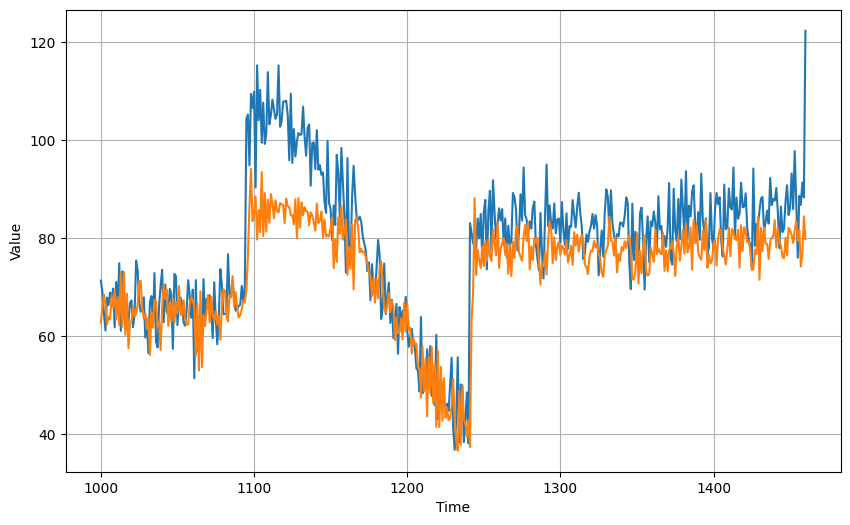

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
mae_metric = keras.metrics.MeanAbsoluteError()
mae_metric.reset_state()
mae_metric.update_state(x_valid, rnn_forecast)
mae = mae_metric.result().numpy()
mae

7.551013